<a href="https://colab.research.google.com/github/unclepete-20/cat_dog_cnn/blob/main/animal_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Laboratorio 10**

## Clasificador de Perros y Gatos utilizando redes neuronales

#### Integrantes:

- Pedro Pablo Arriola Jimenez (20188)
- Oscar Fernando Lopez Barrios (20679)
- Santiago Taracena Puga (20017)
- Yong Bum Park (20117)

In [18]:
# Imports neccesary to work on the project
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Seccion 1.1 - Expliracion de archivos

In [3]:
# We begin the process of unifying the images in their corresponding category.
cat_train_images = sorted(glob.glob('/content/drive/MyDrive/PetImages/Cat/*.jpg'))
dog_train_images = sorted(glob.glob('/content/drive/MyDrive/PetImages/Dog/*.jpg'))

cat_test_images = sorted(glob.glob('/content/drive/MyDrive/PetImages/Cat/*.jpg'))
dog_test_images = sorted(glob.glob('/content/drive/MyDrive/PetImages/Dog/*.jpg'))

In [4]:
print(f"Number of CAT images: {len(cat_train_images)}")
print(f"Number of DOG images: {len(dog_train_images)}")

Number of CAT images: 9000
Number of DOG images: 9500


In [5]:
# Labels are assigned to the images, e.g. 0 for CAT and 1 for DOG.
cat_train_labels = [0] * len(cat_train_images)
dog_train_labels = [1] * len(dog_train_images)

cat_test_labels = [0] * len(cat_test_images)
dog_test_labels = [1] * len(dog_test_images)

In [6]:
# The images and labels from the CAT and DOG folders are now combined into a single dataset.
train_images = cat_train_images + dog_train_images
train_labels = cat_train_labels + dog_train_labels

test_images = cat_test_images + dog_test_images
test_labels = cat_test_labels + dog_test_labels

In [7]:
# The data set is shuffled to ensure a good distribution of the images.
train_indices = np.arange(len(train_images))
np.random.shuffle(train_indices)
train_images = [train_images[i] for i in train_indices]
train_labels = [train_labels[i] for i in train_indices]

test_indices = np.arange(len(test_images))
np.random.shuffle(test_indices)
test_images = [test_images[i] for i in test_indices]
test_labels = [test_labels[i] for i in test_indices]

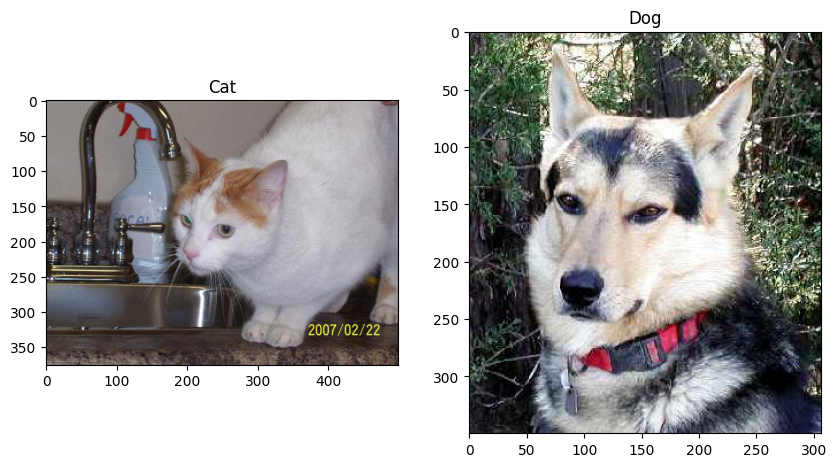

In [8]:
# Both cases are shown in order to observe the differences clearly
train_cat = '/content/drive/MyDrive/PetImages/Cat/'
train_dog = '/content/drive/MyDrive/PetImages/Dog/'

# Cat pic
rand_cat = np.random.randint(0, len(os.listdir(train_cat)))
cat_pic = os.listdir(train_cat)[rand_cat]
cat_pic_address = train_cat + cat_pic

# Dog pic
rand_dog = np.random.randint(0, len(os.listdir(train_dog)))
dog_pic = os.listdir(train_dog)[rand_dog]
dog_address = train_dog + dog_pic

# Load the images and convert to grayscale
cat_load = Image.open(cat_pic_address)
dog_load = Image.open(dog_address)

# Plot the images
f = plt.figure(figsize=(10, 6))
a1 = f.add_subplot(1, 2, 1)
img_plot = plt.imshow(cat_load)
a1.set_title('Cat')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(dog_load)
a2.set_title('Dog')

plt.show()

# Seccion 1.2 - Implementacion del modelo y pre-procesamiento de imagenes

In [9]:
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

In [10]:
def build_model():
    model = tf.keras.models.Sequential([
        mobilenet_base,
        Flatten(),
        Dropout(0.50),
        Dense(256, activation='relu'),
        Dropout(0.20),
        Dense(128, activation='relu'),
        Dropout(0.10),
        Dense(1, activation='sigmoid')
    ])

    mobilenet_base.trainable = False

    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # Add this line to build the model
    #model.build(input_shape=(None, 128, 128, 3))

    model.summary()

    return model

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/PetImages/',
                                                    target_size=(96, 96),
                                                    batch_size=32,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/PetImages/',
                                                        target_size=(96, 96),
                                                        batch_size=32,
                                                        class_mode='binary')

Found 18500 images belonging to 2 classes.
Found 18500 images belonging to 2 classes.


# Seccion 1.3 - Entrenamiento del modelo

In [13]:
# We import the callback class to instantiate the callback function
#callbacks = myCallback()

model = build_model()
history = model.fit(train_generator,
                    epochs=3,
                    validation_data=validation_generator)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 11520)             0         
                                                                 
 dropout_3 (Dropout)         (None, 11520)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               2949376   
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                      

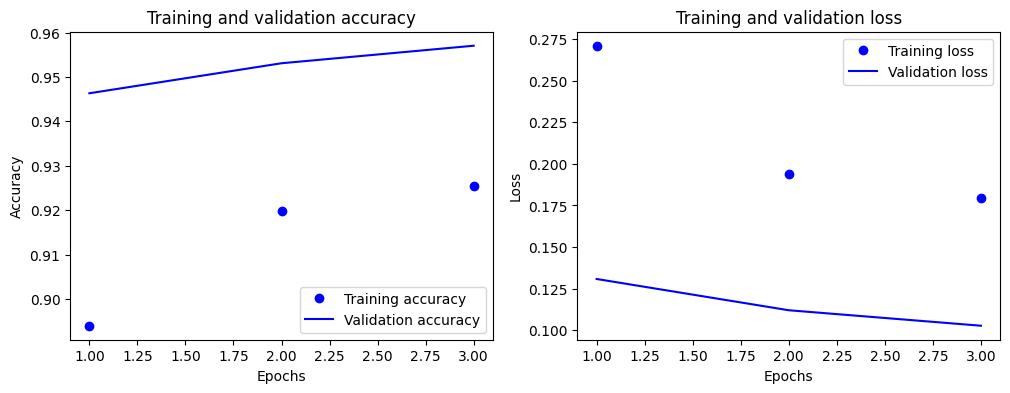

In [14]:
# Function to plot the model's loss and accuracy history to follow patterns that may be useful for insights
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

# Seccion 1.4 - Rendimiento del modelo y predicciones

In [15]:
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

579/579 [==============================] - 205s 353ms/step - loss: 0.1027 - accuracy: 0.9570
Test loss: 0.10271573066711426, Test accuracy: 0.957027018070221


1/1 [==============================] - 1s 1s/step


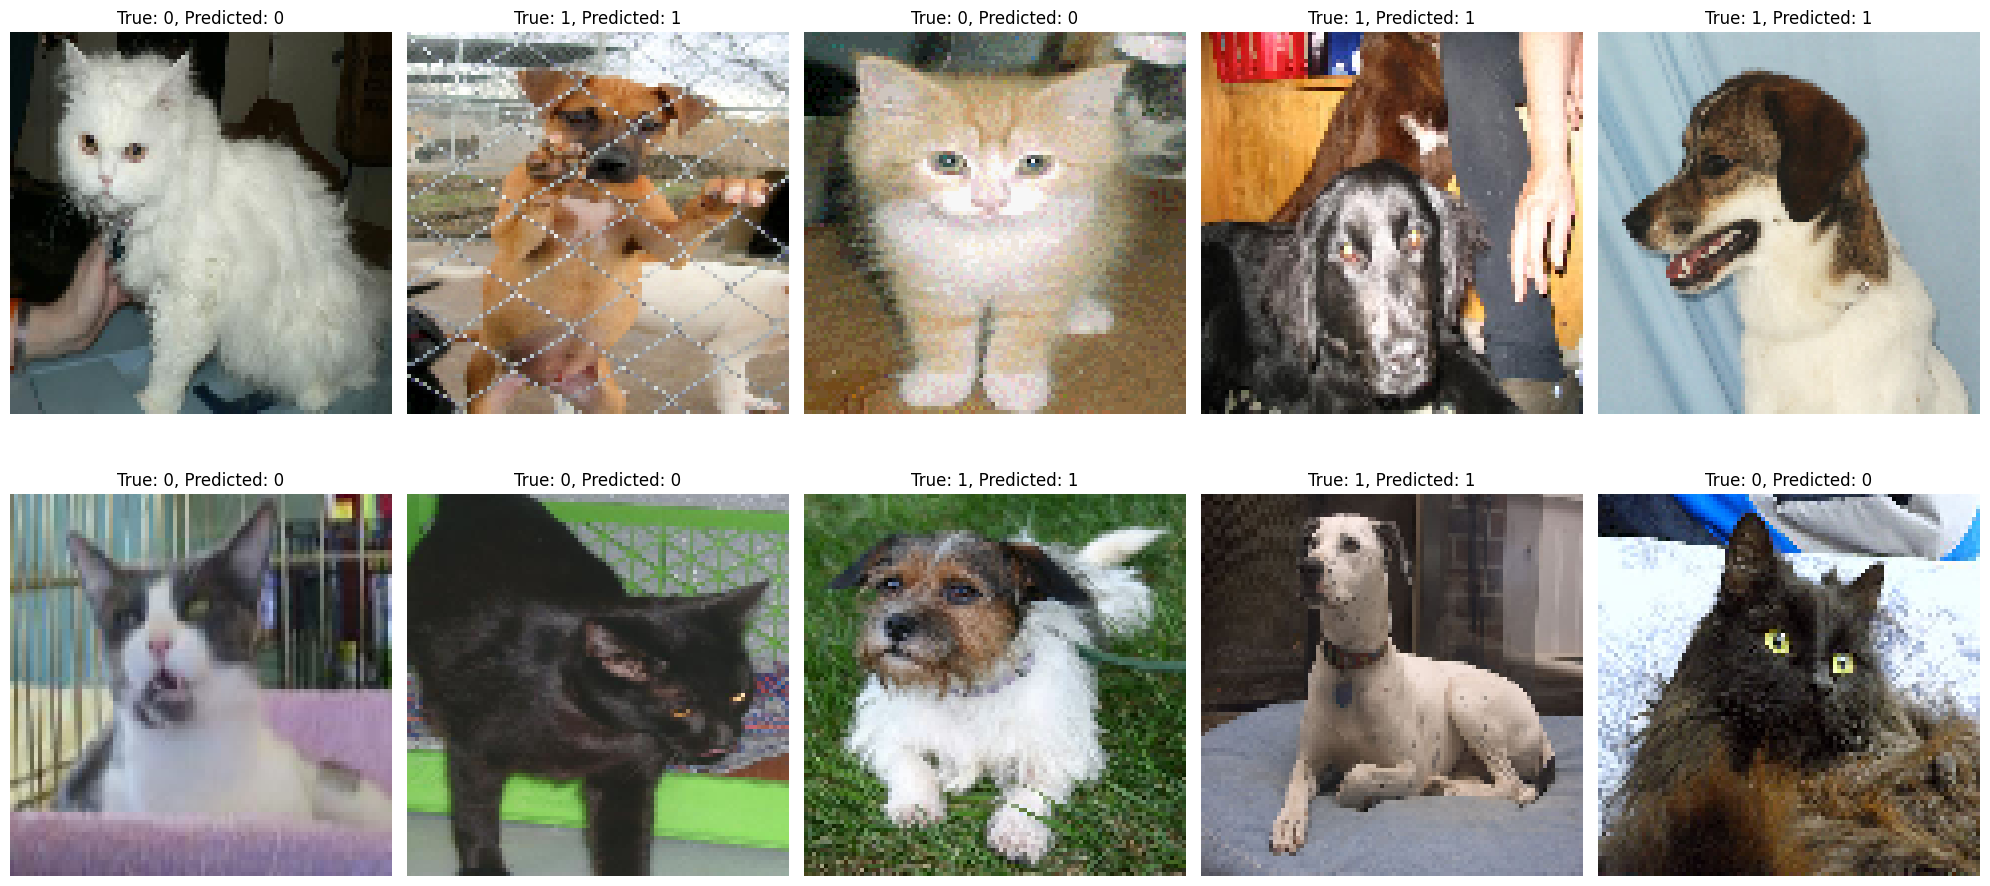

In [17]:
images, labels = next(validation_generator)

batch_predictions = model.predict(images)
y_pred_batch = np.round(batch_predictions).flatten()

import matplotlib.pyplot as plt

# Display the first 10 images along with their true and predicted labels
plt.figure(figsize=(20, 10))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f"True: {int(labels[i])}, Predicted: {int(y_pred_batch[i])}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Debemos recordar que 0 es para GATO y 1 es para PERRO

In [19]:
from sklearn.metrics import f1_score

In [22]:
# Get true labels
y_true = validation_generator.classes

# Get predicted labels
predictions = model.predict(validation_generator)
y_pred = np.round(predictions).flatten()

f1 = f1_score(y_true, y_pred)
print(f"F1 Score: {f1}")

579/579 [==============================] - 217s 372ms/step
F1 Score: 0.518503009683329
